# Project 1 - Medical Appointment No Shows

---

- Data: https://www.kaggle.com/datasets/joniarroba/noshowappointments?select=KaggleV2-May-2016.csv
- What if that possible to predict someone to no-show an appointment?
  
---
 

## Load Cleaned Data for Analysis
See DataCleaning.ipynb for the data cleaning process.

In [1]:
# Dependencies and Setup
import pandas as pd
import hvplot.pandas
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Read in data
df = pd.read_csv('data_cleaned.csv')
df.head()

,Patient_ID,Appointment_ID,Gender,Scheduled_Day,Appointment_Day,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,...,Scheduled_Day_Date,Scheduled_Hour,Scheduled_Day_of_Week,Scheduled_Month,Appointment_Day_Date,Appointment_Day_of_Week,Appointment_Month,Days_Between,lat,lon
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,...,2016-04-29,18,Friday,4,2016-04-29,Friday,4,0,-23.514826,-46.552112
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,...,2016-04-29,16,Friday,4,2016-04-29,Friday,4,0,-23.514826,-46.552112
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,...,2016-04-29,16,Friday,4,2016-04-29,Friday,4,0,-22.788662,-43.079799
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,...,2016-04-29,17,Friday,4,2016-04-29,Friday,4,0,-23.354233,-44.725856
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,...,2016-04-29,16,Friday,4,2016-04-29,Friday,4,0,-23.514826,-46.552112


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110526 entries, 0 to 110525
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Patient_ID               110526 non-null  float64
 1   Appointment_ID           110526 non-null  int64  
 2   Gender                   110526 non-null  object 
 3   Scheduled_Day            110526 non-null  object 
 4   Appointment_Day          110526 non-null  object 
 5   Age                      110526 non-null  int64  
 6   Neighbourhood            110526 non-null  object 
 7   Scholarship              110526 non-null  int64  
 8   Hypertension             110526 non-null  int64  
 9   Diabetes                 110526 non-null  int64  
 10  Alcoholism               110526 non-null  int64  
 11  Handicap                 110526 non-null  int64  
 12  SMS_Received             110526 non-null  int64  
 13  No_Show                  110526 non-null  object 
 14  No_S

## No Show Counts
Twenty percent of patients miss their scheduled appointments. What factors cause this?

In [3]:

# Count no shows and attended
no_show_counts = df['No_Show'].value_counts()
no_show_counts

No_Show
No     88207
Yes    22319
Name: count, dtype: int64

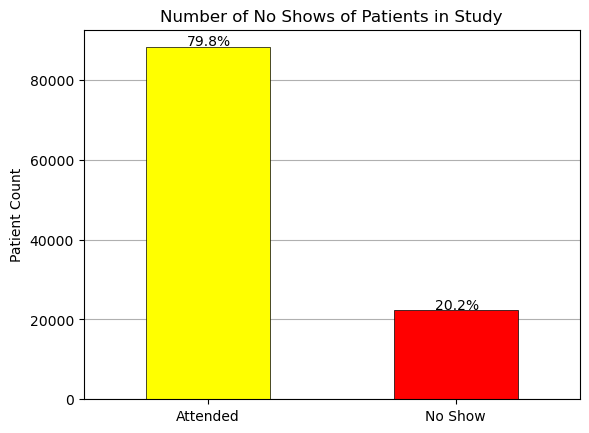

In [4]:
# Bar chart of no shows and attended
ax = no_show_counts.plot(kind = 'bar', 
        xlabel = '',
        ylabel = 'Patient Count',
        title = 'Number of No Shows of Patients in Study',
        edgecolor = 'black',
        color = no_show_counts.replace({no_show_counts['No']: 'yellow', no_show_counts['Yes']: 'red'}),
        linewidth = 0.5,
        rot = 0,
        )
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_xticklabels(['Attended','No Show'])

# Add percent lables to bars
no_show_percent = [round(100*no_show_counts['No'] / len(df['No_Show']),1), 
                  round(100*no_show_counts['Yes'] / len(df['No_Show']),1)]
i = 0
for p in ax.patches:
    ax.annotate(str(no_show_percent[i])  + '%', (p.get_x()  + p.get_width()/3, p.get_height() * 1.005))
    i += 1

# Save the figure
plt.savefig("output/Num_no_shows_bar.png")
# Show figure
plt.show()

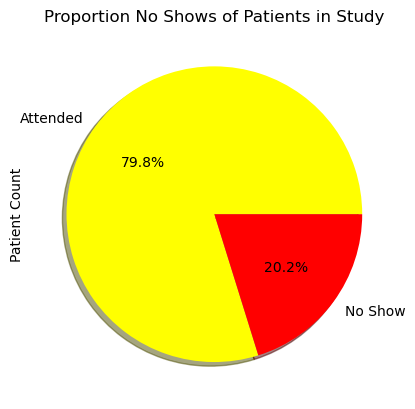

In [5]:
# Pie graph of no shows and attended
labels = ['Attended','No Show']
colors = ['yellow','red']
ax = no_show_counts.plot(kind = 'pie', 
        xlabel = '',
        ylabel = 'Patient Count',
        title = 'Proportion No Shows of Patients in Study',
        colors = colors,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        )

# Save the figure
plt.savefig("output/Num_no_shows_pie.png")
# Show figure
plt.show()

## Demographics
- Do factors like age and gender play a role in missed appointments?
- Are people on scholarship (welfare) more or less likely to miss appointments?
- Does location play a role in missed appointments?

Conclusions:
- People between ages 10-35 are most likely to miss appointments. In genearl, children and older people are less likely to miss appointments.
- Males and Females are equally likely to miss appointments.
- People on scholarship (welfare) are more likely to miss appointments.
- People in areas of greater population density are more likely to miss appointments.

### Age

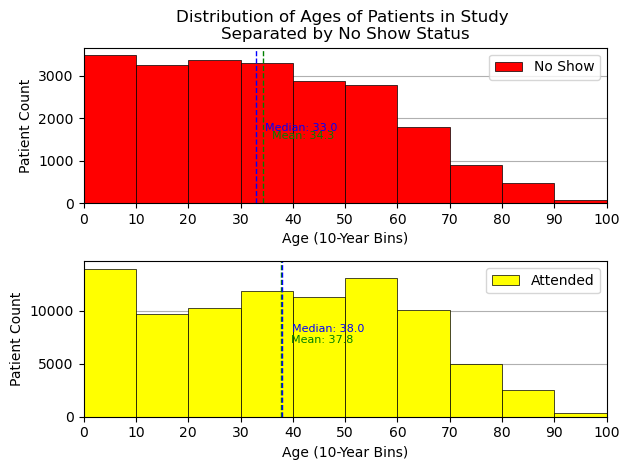

In [6]:
# Distribution of ages of patients in study, separated by no show and attended
fig, ax = plt.subplots(nrows=2, ncols=1)

# Bin data into 5-year age increments
xticks = np.arange(0,120,10).tolist()
bins = np.arange(0,120,10).tolist()

# No shows
df[df['No_Show_Boolean']==True].plot(ax=ax[0],
        kind = 'hist', 
        y = 'Age', 
        xlabel = 'Age (10-Year Bins)',
        ylabel = 'Patient Count',
        title = 'Distribution of Ages of Patients in Study \nSeparated by No Show Status',
        edgecolor = 'black',
        linewidth = 0.5,
        xlim = [0,100],
        xticks = xticks,
        bins  = bins,
        color = 'red',
        label = 'No Show'
        )
# Add vertical lines for average and median 
avg = df[df['No_Show_Boolean']==True]['Age'].mean()
ax[0].axvline(avg, color='green', linestyle='dashed', linewidth=1)
ax[0].text(avg*1.05, 1500, 'Mean: {:.1f}'.format(avg), fontsize = 8, color='green')
med = df[df['No_Show_Boolean']==True]['Age'].median()
ax[0].axvline(med, color='blue', linestyle='dashed', linewidth=1)
ax[0].text(med*1.05, 1700, 'Median: {:.1f}'.format(med), fontsize = 8, color='blue')
ax[0].grid(axis='y')
ax[0].set_axisbelow(True)

# Attended
df[df['No_Show_Boolean']==False].plot(ax=ax[1],
        kind = 'hist', 
        y = 'Age', 
        xlabel = 'Age (10-Year Bins)',
        ylabel = 'Patient Count',
        # title = 'Distribution of Ages of Patients in Study \nSeparated by No Show Status',
        edgecolor = 'black',
        linewidth = 0.5,
        xlim = [0,100],
        xticks = xticks,
        bins  = bins,
        color = 'yellow',
        label = 'Attended'
        )
# Add vertical lines for average and median 
avg = df[df['No_Show_Boolean']==False]['Age'].mean()
ax[1].axvline(avg, color='green', linestyle='dashed', linewidth=1)
ax[1].text(avg*1.05, 7000, 'Mean: {:.1f}'.format(avg), fontsize = 8, color='green')
med = df[df['No_Show_Boolean']==False]['Age'].median()
ax[1].axvline(med, color='blue', linestyle='dashed', linewidth=1)
ax[1].text(med*1.05, 8000, 'Median: {:.1f}'.format(med), fontsize = 8, color='blue')
ax[1].grid(axis='y')
ax[1].set_axisbelow(True)

plt.tight_layout()

# Save the figure
plt.savefig("output/Age_distribution_separated.png")
# Show figure
plt.show()

### Gender

### Scholarship

### Location

In [7]:
# List of neighborhoods
neighborhoods = df['Neighbourhood'].unique().tolist()

In [8]:
# Create neighborhoods dataframe
neighborhood_df = df[["Neighbourhood","lat","lon"]]
neighborhood_df = neighborhood_df.drop_duplicates()
neighborhood_df = neighborhood_df.reset_index()
neighborhood_df.drop(columns=['index'], inplace=True)
neighborhood_df

,Neighbourhood,lat,lon
0,JARDIM DA PENHA,-23.514826,-46.552112
1,MATA DA PRAIA,-22.788662,-43.079799
2,PONTAL DE CAMBURI,-23.354233,-44.725856
3,REPÚBLICA,-20.269941,-40.293034
4,GOIABEIRAS,-20.270612,-40.302859
...,...,...,...
76,FRADINHOS,-20.307131,-40.326980
77,NAZARETH,-20.310290,-40.316110
78,AEROPORTO,-3.775718,-38.527795
79,ILHAS OCEÂNICAS DE TRINDADE,-23.350815,-44.724037


In [9]:
# Number of patients per neighborhood, to add to neighborhoods dataframe
num_patients_per_neighborhoood = df['Neighbourhood'].value_counts()
num_patients_per_neighborhoood = pd.DataFrame(num_patients_per_neighborhoood)
num_patients_per_neighborhoood = num_patients_per_neighborhoood.reset_index()
num_patients_per_neighborhoood.rename(columns={'count':'Patient_Count'},inplace=True)
num_patients_per_neighborhoood

,Neighbourhood,Patient_Count
0,JARDIM CAMBURI,7717
1,MARIA ORTIZ,5805
2,RESISTÊNCIA,4431
3,JARDIM DA PENHA,3877
4,ITARARÉ,3514
...,...,...
76,ILHA DO BOI,35
77,ILHA DO FRADE,10
78,AEROPORTO,8
79,ILHAS OCEÂNICAS DE TRINDADE,2


In [10]:
# No Show proportion per neighborhood, to add to neighborhoods dataframe
no_shows_per_neighborhoood = pd.DataFrame(df.groupby("Neighbourhood")["No_Show_Boolean"].mean())
no_shows_per_neighborhoood = no_shows_per_neighborhoood.reset_index()
no_shows_per_neighborhoood.rename(columns={'No_Show_Boolean':'No_Show_Proportion'},inplace=True)
no_shows_per_neighborhoood

,Neighbourhood,No_Show_Proportion
0,AEROPORTO,0.125000
1,ANDORINHAS,0.230327
2,ANTÔNIO HONÓRIO,0.184502
3,ARIOVALDO FAVALESSA,0.219858
4,BARRO VERMELHO,0.215130
...,...,...
76,SÃO JOSÉ,0.216490
77,SÃO PEDRO,0.210376
78,TABUAZEIRO,0.182950
79,UNIVERSITÁRIO,0.210526


In [11]:
# Merge patients per neighborhood into neigborhoods dataframe
neighborhood_df = pd.merge(neighborhood_df, num_patients_per_neighborhoood, how = 'left', on = 'Neighbourhood')

In [12]:
# Merge no shows per neighborhood into neigborhoods dataframe
neighborhood_df = pd.merge(neighborhood_df, no_shows_per_neighborhoood, how = 'left', on = 'Neighbourhood')

In [13]:
# Neigborhoods dataframe for map plot
neighborhood_df

,Neighbourhood,lat,lon,Patient_Count,No_Show_Proportion
0,JARDIM DA PENHA,-23.514826,-46.552112,3877,0.162755
1,MATA DA PRAIA,-22.788662,-43.079799,644,0.170807
2,PONTAL DE CAMBURI,-23.354233,-44.725856,69,0.173913
3,REPÚBLICA,-20.269941,-40.293034,835,0.171257
4,GOIABEIRAS,-20.270612,-40.302859,700,0.195714
...,...,...,...,...,...
76,FRADINHOS,-20.307131,-40.326980,258,0.186047
77,NAZARETH,-20.310290,-40.316110,135,0.214815
78,AEROPORTO,-3.775718,-38.527795,8,0.125000
79,ILHAS OCEÂNICAS DE TRINDADE,-23.350815,-44.724037,2,1.000000


In [14]:
# Map of neighborhoods, sized by patient count and colored by no show proportion
neighborhood_map = neighborhood_df.hvplot.points(
    "lon",
    "lat",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 600,
    size = "Patient_Count",
    scale = .5,
    color = "No_Show_Proportion",
    cmap = "tab20", # https://holoviews.org/user_guide/Colormaps.html#Styling_Plots.html
    hover_cols = ["Patient_Count", "No_Show_Proportion"],
    title = "Patient Neighborhoods, Sized by Patient Count and Colored by No Show Proportion"
)

# Save the map as html file
hvplot.save(neighborhood_map, "output/No_shows_by_neighborhood.html")
# Display the map plot
neighborhood_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (No_Show_Proportion,Patient_Count)

## SMS and Condition Questions
- What impact does the SMS received play in missed appointments?
- Do patients who answered positively to a condition question show up at a different rate than those who did not?

Conclusions: 
- People who received an SMS were actually more likely to miss appointments. Perhaps this has to do with the type of people who opt out of SMS notifications (i.e. they are more likely to make their appointment).
- People no condition (alcohilism, diabetes, hypertension, handicap) are more likle to miss appointments than those wiht a condition. Of those with a condition, people with hypertension are least likely to no show and people with alcoholism are most likley to no show.

### SMS Received

### Condition Questions

## No Shows vs. DateTime Stats

### Days Between Scheduling Appointment and Appointment Day
Does a greater number of days between scheduling appointment and the appointment day result in a higher percentage of no shows? Is there an optimal time to schedule an appointment so you do not miss it?

Conclusions: 
- For no shows, median (mean) number of days between scheduling and appointment is 11 days (15.8 days)
- For attended, median (mean) number of days between scheduling and appointment is 2 days (8.8 days)
- So yes, no shows have a higher median and mean number of days between scheduling and appointment, suggesting that having fewer days between scheduling and appointment reduces the likelihood of no shows.
- When the number of days between scheduling and appointment is between 0-42 days, the percentage of no shows gradually increases as number of days between scheduling and appointment increase.
- When the number of days between scheduling and appointment is between 42-91 days, the percentage of no shows gradually decreases as number of days between scheduling and appointment increase. (Huh, wonder why?)
- After 91 days, the percentage of no shows varies quite a bit.
- Day-of appointments are least likely to have no-shows.
- It seems as if the optimal time to schedule an appointment is either 0-2 days or 80-90 days. Perhaps 3-month routine checkups don't see as many no shows.

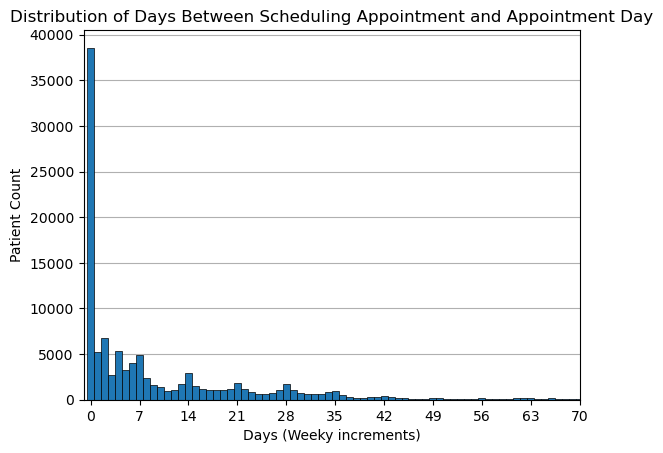

In [15]:
# Distribution of of days between scheduling appointment and appointment day
xticks = np.arange(0,71,7).tolist()
bins = np.arange(-.5,185,1).tolist()
ax = df.plot(kind = 'hist', 
        y = 'Days_Between', 
        xlabel = 'Days (Weeky increments)',
        ylabel = 'Patient Count',
        title = 'Distribution of Days Between Scheduling Appointment and Appointment Day',
        edgecolor = 'black',
        linewidth = 0.5,
        xlim = [-1,70],
        xticks = xticks,
        bins = bins,
        )
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.get_legend().remove()

# Save the figure
plt.savefig("output/Days_between_distribution.png")
# Show figure
plt.show()

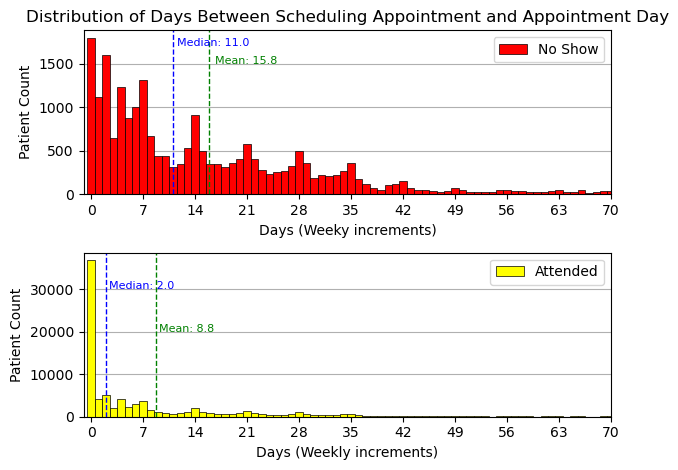

In [16]:
# Distribution of days between scheduling appointment and appointment day, separated by no show and attended
fig, ax = plt.subplots(nrows=2, ncols=1)

# No Shows
xticks = np.arange(0,71,7).tolist()
bins = np.arange(-.5,185,1).tolist()
df[df['No_Show_Boolean']==True].plot(ax=ax[0],
        kind = 'hist', 
        y = 'Days_Between', 
        xlabel = 'Days (Weeky increments)',
        ylabel = 'Patient Count',
        title = 'Distribution of Days Between Scheduling Appointment and Appointment Day',
        edgecolor = 'black',
        linewidth = 0.5,
        xlim = [-1,70],
        xticks = xticks,
        bins  = bins,
        color = 'red',
        label = 'No Show'
        )
# Add vertical lines for average and median 
avg = df[df['No_Show_Boolean']==True]['Days_Between'].mean()
ax[0].axvline(avg, color='green', linestyle='dashed', linewidth=1)
ax[0].text(avg*1.05, 1500, 'Mean: {:.1f}'.format(avg), fontsize = 8, color='green')
med = df[df['No_Show_Boolean']==True]['Days_Between'].median()
ax[0].axvline(med, color='blue', linestyle='dashed', linewidth=1)
ax[0].text(med*1.05, 1700, 'Median: {:.1f}'.format(med), fontsize = 8, color='blue')
ax[0].grid(axis='y')
ax[0].set_axisbelow(True)

# Attended
df[df['No_Show_Boolean']==False].plot(ax=ax[1],
        kind = 'hist', 
        y = 'Days_Between', 
        xlabel = 'Days (Weekly increments)',
        ylabel = 'Patient Count',
        #title = 'Distribution of Days Between Scheduling Appointment and Appointment Day',
        edgecolor = 'black',
        linewidth = 0.5,
        xlim = [-1,70],
        xticks = xticks,
        bins  = bins,
        color = 'yellow',
        label = 'Attended'
        )
# Add vertical lines for average and median 
avg = df[df['No_Show_Boolean']==False]['Days_Between'].mean()
ax[1].axvline(avg, color='green', linestyle='dashed', linewidth=1)
ax[1].text(avg*1.05, 20000, 'Mean: {:.1f}'.format(avg), fontsize = 8, color='green')
med = df[df['No_Show_Boolean']==False]['Days_Between'].median()
ax[1].axvline(med, color='blue', linestyle='dashed', linewidth=1)
ax[1].text(med*1.2, 30000, 'Median: {:.1f}'.format(med), fontsize = 8, color='blue')
ax[1].grid(axis='y')
ax[1].set_axisbelow(True)
plt.tight_layout()

# Save the figure
plt.savefig("output/Days_between_distribution_separated.png")
# Show figure
plt.show()

In [17]:
# Proportion of no shows by days between
no_shows_by_days_between = df.groupby('Days_Between')['No_Show_Boolean'].mean().reset_index()
no_shows_by_days_between.rename(columns={'No_Show_Boolean':'No_Show_Proportion'},inplace=True)
no_shows_by_days_between['Attended_Proportion'] = 1-no_shows_by_days_between['No_Show_Proportion']
no_shows_by_days_between

,Days_Between,No_Show_Proportion,Attended_Proportion
0,0,0.046471,0.953529
1,1,0.214108,0.785892
2,2,0.238216,0.761784
3,3,0.235294,0.764706
4,4,0.232703,0.767297
...,...,...,...
124,155,0.600000,0.400000
125,162,0.181818,0.818182
126,169,0.125000,0.875000
127,176,0.375000,0.625000


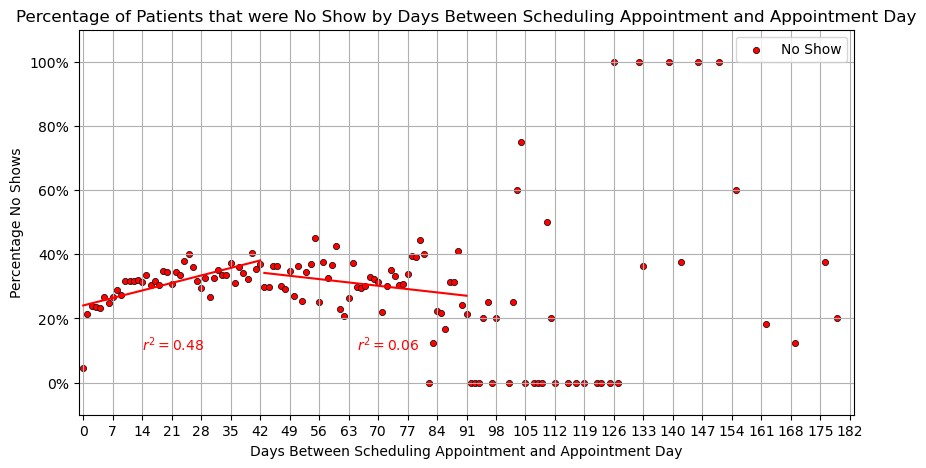

In [18]:
# Scatter plot 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
xticks = np.arange(0,190,7).tolist()
no_shows_by_days_between.plot(ax = ax,
        kind = 'scatter', 
        x = 'Days_Between',
        y = 'No_Show_Proportion', 
        xlabel = 'Days Between Scheduling Appointment and Appointment Day',
        ylabel = 'Percentage No Shows',
        title = 'Percentage of Patients that were No Show by Days Between Scheduling Appointment and Appointment Day',
        edgecolor = 'black',
        linewidth = 0.5,
        xlim = [-1,183],
        xticks = xticks,
        grid = True,
        color = 'red',
        label = 'No Show'
        )

# Find regression model using linregress
# Break linear regression into three segments from observation of the data
# Days_Between <=42
xdata = no_shows_by_days_between[no_shows_by_days_between['Days_Between']<=42]['Days_Between']
ydata = no_shows_by_days_between[no_shows_by_days_between['Days_Between']<=42]['No_Show_Proportion']
slope, intercept, rvalue, pvalue, stderr = linregress(xdata, ydata) 
r_squared = rvalue*rvalue # The square of rvalue is equal to the coefficient of determination
ylinreg = slope*xdata + intercept # regression values
ax.plot(xdata, ylinreg, '-r')
ax.text(14,.1,'$r^2 = %0.2f$'% r_squared, fontsize = 10, color='red')
# Days_Between >42 and <=91
xdata = no_shows_by_days_between[(no_shows_by_days_between['Days_Between']>42) & (no_shows_by_days_between['Days_Between']<=91)]['Days_Between']
ydata = no_shows_by_days_between[(no_shows_by_days_between['Days_Between']>42) & (no_shows_by_days_between['Days_Between']<=91)]['No_Show_Proportion']
slope, intercept, rvalue, pvalue, stderr = linregress(xdata, ydata) 
r_squared = rvalue*rvalue # The square of rvalue is equal to the coefficient of determination
ylinreg = slope*xdata + intercept # regression values
ax.plot(xdata, ylinreg, '-r')
ax.text(65,.1,'$r^2 = %0.2f$'% r_squared, fontsize = 10, color='red')

# Change format of yticks to percentages
vals = ax.get_yticks() 
ax.set_yticks(vals)
ax.set_yticklabels(['{:,.0%}'.format(ytick) for ytick in vals])
ax.set_ylim([-.1,1.1])

# Save the figure
plt.savefig("output/No_shows_by_days_between_scatter.png")
# Show figure
plt.show()

In [19]:
# Bin data into week increments for another scatterplot

# Establish the bins
bins = np.arange(0,183,7).tolist()
midpoints = np.arange(3.5,183,7).tolist()
no_shows_by_days_between_binned_temp = no_shows_by_days_between.copy()
# Use `pd.cut` to categorize Days_Between based on the bins.
no_shows_by_days_between_binned_temp['Days_Between_Binned'] = pd.cut(no_shows_by_days_between_binned_temp['Days_Between'], 
                                                             bins = bins, 
                                                             #labels = labels, 
                                                             include_lowest = True,
                                                             right = True)
#  Calculate averages for the no show and attended proportions.
columns_to_avg = ['No_Show_Proportion','Attended_Proportion']
no_shows_by_days_between_binned = no_shows_by_days_between_binned_temp.groupby(['Days_Between_Binned'], observed = False)
no_shows_by_days_between_binned = no_shows_by_days_between_binned[columns_to_avg].mean().round(2)
no_shows_by_days_between_binned['Midpoint'] = midpoints
no_shows_by_days_between_binned = no_shows_by_days_between_binned.reset_index()
no_shows_by_days_between_binned

,Days_Between_Binned,No_Show_Proportion,Attended_Proportion,Midpoint
0,"(-0.001, 7.0]",0.22,0.78,3.5
1,"(7.0, 14.0]",0.31,0.69,10.5
2,"(14.0, 21.0]",0.32,0.68,17.5
3,"(21.0, 28.0]",0.35,0.65,24.5
4,"(28.0, 35.0]",0.33,0.67,31.5
5,"(35.0, 42.0]",0.35,0.65,38.5
6,"(42.0, 49.0]",0.32,0.68,45.5
7,"(49.0, 56.0]",0.33,0.67,52.5
8,"(56.0, 63.0]",0.31,0.69,59.5
9,"(63.0, 70.0]",0.32,0.68,66.5


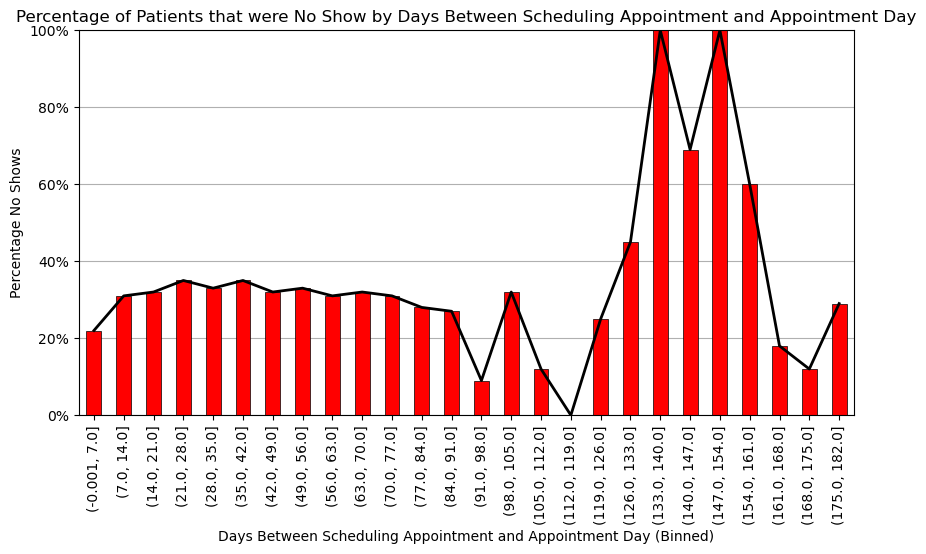

In [20]:
# Bar plot proportion of no shows by days between scheduliing appointment and appointment day
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
no_shows_by_days_between_binned.plot(ax = ax,
        kind = 'bar', 
        x = 'Days_Between_Binned',
        y = 'No_Show_Proportion', 
        edgecolor = 'black',
        linewidth = 0.5,
        color = 'red',
        #label = 'No Show',
        #xlim = [-1,191],
        #ylim = [0,1],
        #grid = True,
        #xlabel = 'Days Between Scheduling Appointment and Appointment Day (Binned)',
        #ylabel = 'Percentage of No Shows',
        #title = 'Percentage of Patients No Show by Days Between Scheduling Appointment and Appointment Day',
        )

# Add line graph for visual appeal
no_shows_by_days_between_binned.plot(ax = ax,
        kind = 'line', 
        x = 'Days_Between_Binned',
        y = 'No_Show_Proportion', 
        linewidth = 2,
        color = 'black',
        #label = 'No Show',
        #xlim = [-1,191],
        ylim = [0,1],
        rot = 90,
        #grid = True,
        xlabel = 'Days Between Scheduling Appointment and Appointment Day (Binned)',
        ylabel = 'Percentage No Shows',
        title = 'Percentage of Patients that were No Show by Days Between Scheduling Appointment and Appointment Day',
        )
ax.grid(axis='y')
ax.set_axisbelow(True)

# Change format of yticks to percentages
vals = ax.get_yticks() 
ax.set_yticks(vals)
ax.set_yticklabels(['{:,.0%}'.format(ytick) for ytick in vals])
ax.set_ylim([0,1])

# Remove legend
ax.get_legend().remove()

# Save the figure
plt.savefig("output/No_shows_by_days_betwen_bar.png")
# Show figure
plt.show()

### No Shows by Appointment Day of Week
Is there a day of the week that has a higher volume of missed appointments? Is it more likely that appointments on Friday or Saturday have a higher proportion of no shows than midweek days?

Conclusions: 
- Friday and Saturday have the highest percentages of no shows.
- Monday through Thursday have lower percentages of no shows, with the proportion of missed appointments decreasing as the week progresses. So Thursday seems to be the best day to schedule an appointment if you want to have the highest likelihood of not becoming a no show!

In [21]:
# Number of patients that had appointment by day of week
appt_day_of_week = df.groupby('Appointment_Day_of_Week')['Patient_ID'].count().reset_index()
appt_day_of_week.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
appt_day_of_week = appt_day_of_week.reindex(index=[1,4,5,3,0,2]).reset_index() # reorder rows 
appt_day_of_week.drop(columns=['index'], inplace=True) # remove old index
appt_day_of_week


,Appointment_Day_of_Week,Patient_Count
0,Monday,22714
1,Tuesday,25640
2,Wednesday,25867
3,Thursday,17247
4,Friday,19019
5,Saturday,39


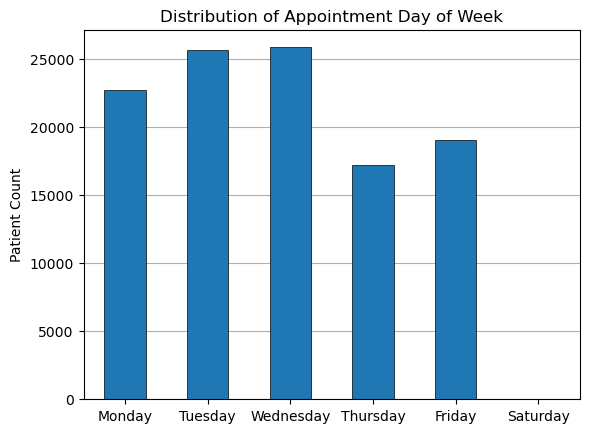

In [22]:
# Distribution of appointment day of week
ax = appt_day_of_week.plot(kind = 'bar',
        x = 'Appointment_Day_of_Week',
        y = 'Patient_Count', 
        xlabel = '',
        ylabel = 'Patient Count',
        title = 'Distribution of Appointment Day of Week',
        edgecolor = 'black',
        linewidth = 0.5,
        rot = 0,
        #xlim = [-1,70],
        #xticks = xticks,
        #bins = bins,
        )
ax.grid(axis='y')
ax.set_axisbelow(True)

# Remove legend
ax.get_legend().remove()

# Save the figure
plt.savefig("output/Appointment_day_of_week_distribution.png")
# Show figure
plt.show()

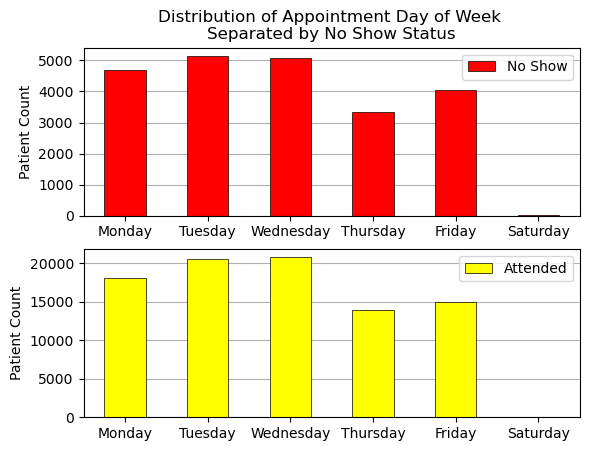

In [23]:
# Distribution of appointment day of week
# Separated by no show and attended

# No Shows
appt_day_of_week_no_show = df[df['No_Show_Boolean']==True].groupby('Appointment_Day_of_Week')['Patient_ID'].count().reset_index()
appt_day_of_week_no_show.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
appt_day_of_week_no_show = appt_day_of_week_no_show.reindex(index=[1,4,5,3,0,2]).reset_index() # reorder rows 
appt_day_of_week_no_show.drop(columns=['index'], inplace=True) # remove old index

fig, ax = plt.subplots(nrows=2, ncols=1)
plot1 = appt_day_of_week_no_show.plot(ax=ax[0],
        kind = 'bar', 
        x = 'Appointment_Day_of_Week',
        y = 'Patient_Count', 
        xlabel = '',
        ylabel = 'Patient Count',
        title = 'Distribution of Appointment Day of Week \nSeparated by No Show Status',
        edgecolor = 'black',
        color='red',
        linewidth = 0.5,
        rot = 0,
        label = "No Show",
        #ylim = [0,.18]
        )
ax[0].grid(axis='y')
ax[0].set_axisbelow(True)
# Add legend
ax[0].legend()

# Attended
appt_day_of_week_attended = df[df['No_Show_Boolean']==False].groupby('Appointment_Day_of_Week')['Patient_ID'].count().reset_index()
appt_day_of_week_attended.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
appt_day_of_week_attended = appt_day_of_week_attended.reindex(index=[1,4,5,3,0,2]).reset_index() # reorder rows 
appt_day_of_week_attended.drop(columns=['index'], inplace=True) # remove old index

plot2 = appt_day_of_week_attended.plot(ax=ax[1],
        kind = 'bar', 
        x = 'Appointment_Day_of_Week',
        y = 'Patient_Count', 
        xlabel = '',
        ylabel = 'Patient Count',
        # title = 'Distribution of Appointment Day of Week',
        edgecolor = 'black',
        color='yellow',
        linewidth = 0.5,
        rot = 0,
        label = "Attended",
        )
ax[1].grid(axis='y')
ax[1].set_axisbelow(True)
# Add legend
ax[1].legend()

# Save the figure
plt.savefig("output/Appointment_day_of_week_distribution_separated.png")
# Show figure
plt.show()

In [24]:
# Find proportion of no shows by appointment day of week
no_shows_by_appt_day_of_week = df.groupby('Appointment_Day_of_Week')['No_Show_Boolean'].mean().reset_index()
no_shows_by_appt_day_of_week.rename(columns={'No_Show_Boolean':'No_Show_Proportion'},inplace=True)
no_shows_by_appt_day_of_week['Attended_Proportion'] = 1-no_shows_by_appt_day_of_week['No_Show_Proportion']
no_shows_by_appt_day_of_week = no_shows_by_appt_day_of_week.reindex(index=[1,4,5,3,0,2]).reset_index() # reorder rows 
no_shows_by_appt_day_of_week.drop(columns=['index'], inplace=True) # remove old index
no_shows_by_appt_day_of_week

,Appointment_Day_of_Week,No_Show_Proportion,Attended_Proportion
0,Monday,0.206481,0.793519
1,Tuesday,0.200936,0.799064
2,Wednesday,0.196892,0.803108
3,Thursday,0.193541,0.806459
4,Friday,0.212261,0.787739
5,Saturday,0.230769,0.769231


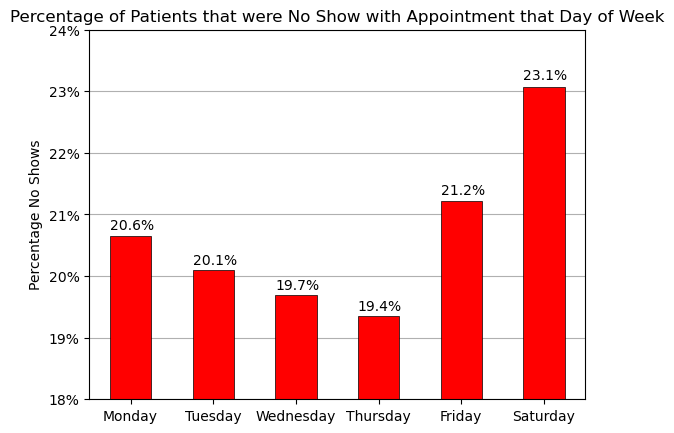

In [25]:
# Bar plot of no shows by appointment day of week
ax = no_shows_by_appt_day_of_week.plot(kind = 'bar', 
        # stacked = True,
        x = 'Appointment_Day_of_Week',
        y = 'No_Show_Proportion',
        xlabel = '',
        ylabel = 'Percentage No Shows',
        title = 'Percentage of Patients that were No Show with Appointment that Day of Week',
        edgecolor = 'black',
        color = 'red',
        linewidth = 0.5,
        rot = 0,
        ylim = [0.18,0.24],
        #yticks=[.18,.19,.20,.21,.22,.23,.24]
        )
# horizontal grid lines
ax.grid(axis='y') 
ax.set_axisbelow(True)

# Change format of yticks to percentages
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels(['{:,.0%}'.format(ytick) for ytick in vals])

# Label bar heights
for p in ax.patches:
    ax.annotate(str(round(p.get_height()*100,1)) + '%', (p.get_x(), p.get_height() * 1.005))

# Remove legend
ax.get_legend().remove()

# Save the figure
plt.savefig("output/No_shows_by_appointment_day_of_week.png")
# Show figure
plt.show()

### No Shows by Appointment Month
Is there a month of the year (or season in general) that has a higher volume of missed appointments? Is it more likely that appointments in the summer have a higher proportion of no shows than appointments in the fall, spring, and winter?

It turns out there is not enough data in the dataset for this analysis, since the appointments only span three months (April, May, June). This will bias towards the shorter Days_Between for the months at the end of the time period, which is going to bias towards a smaller no show percentage for months at the end of the time period. 

In [26]:
# Number of patients that had appointment that month
appt_month = df.groupby('Appointment_Month')['Patient_ID'].count().reset_index()
appt_month.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
appt_month

,Appointment_Month,Patient_Count
0,4,3235
1,5,80841
2,6,26450


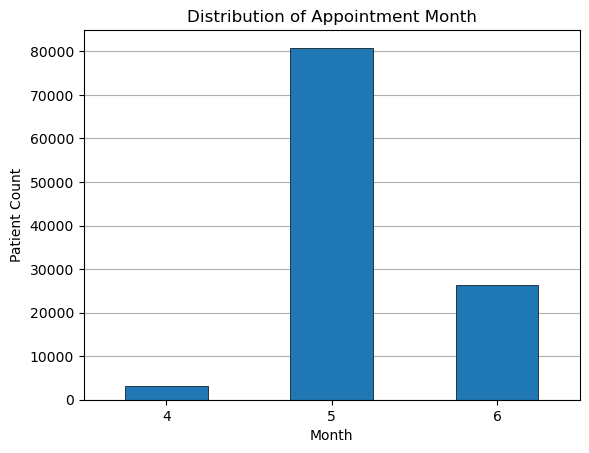

In [27]:
# Distribution of appointment month
ax = appt_month.plot(kind = 'bar',
        x = 'Appointment_Month',
        y = 'Patient_Count', 
        xlabel = 'Month',
        ylabel = 'Patient Count',
        title = 'Distribution of Appointment Month',
        edgecolor = 'black',
        linewidth = 0.5,
        rot = 0,
        #xlim = [-1,70],
        #xticks = xticks,
        #bins = bins,
        )
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.get_legend().remove()
plt.show()

In [28]:
# Find proportion of no shows by appointment month
no_shows_by_appt_month = df.groupby('Appointment_Month')['No_Show_Boolean'].mean().reset_index()
no_shows_by_appt_month.rename(columns={'No_Show_Boolean':'No_Show_Proportion'},inplace=True)
no_shows_by_appt_month['Attended_Proportion'] = 1-no_shows_by_appt_month['No_Show_Proportion']
no_shows_by_appt_month

,Appointment_Month,No_Show_Proportion,Attended_Proportion
0,4,0.195672,0.804328
1,5,0.207865,0.792135
2,6,0.184575,0.815425


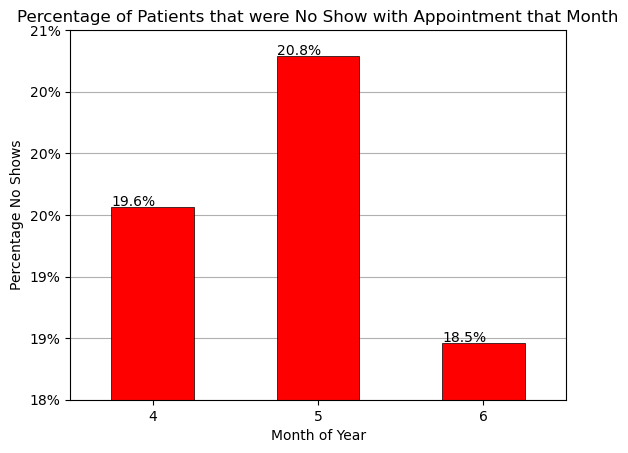

In [29]:
# Bar plot of no shows by appointment month
ax = no_shows_by_appt_month.plot(kind = 'bar', 
        stacked = True,
        x = 'Appointment_Month',
        y = 'No_Show_Proportion',
        xlabel = 'Month of Year',
        ylabel = 'Percentage No Shows',
        title = 'Percentage of Patients that were No Show with Appointment that Month',
        edgecolor = 'black',
        color = 'red',
        linewidth = 0.5,
        rot = 0,
        ylim = [0.18,0.21],
        #yticks=[.18,.19,.20,.21,.22,.23,.24]
        )
# horizontal grid lines
ax.grid(axis='y') 
ax.set_axisbelow(True)

# Change format of yticks to percentages
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels(['{:,.0%}'.format(ytick) for ytick in vals])

# Label bar heights
for p in ax.patches:
    ax.annotate(str(round(p.get_height()*100,1)) + '%', (p.get_x(), p.get_height() * 1.0005))

# Remove legend
ax.get_legend().remove()

plt.show()

### No Shows by Scheduling Day of Week
Does the day of week that an appointment is scheduled impact the chances of the patient showing up?

Conclusions:
- For Monday-Friday, the day of week that the appointment is scheduled does not seem to affect the cahnces of the patient showing up.
- However, for appointments scheduled on Saturday, there is a very small chance of no shows. It does not appear that Saturday has more same day appointments, so I am unsure of why appointments scheduled on Saturday have less chance of being missed.

In [30]:
# Number of patients that scheduled on day of week
scheduled_day_of_week = df.groupby('Scheduled_Day_of_Week')['Patient_ID'].count().reset_index()
scheduled_day_of_week.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
scheduled_day_of_week = scheduled_day_of_week.reindex(index=[1,4,5,3,0,2]).reset_index() # reorder rows 
scheduled_day_of_week.drop(columns=['index'], inplace=True) # remove old index
scheduled_day_of_week


,Scheduled_Day_of_Week,Patient_Count
0,Monday,23084
1,Tuesday,26168
2,Wednesday,24262
3,Thursday,18073
4,Friday,18915
5,Saturday,24


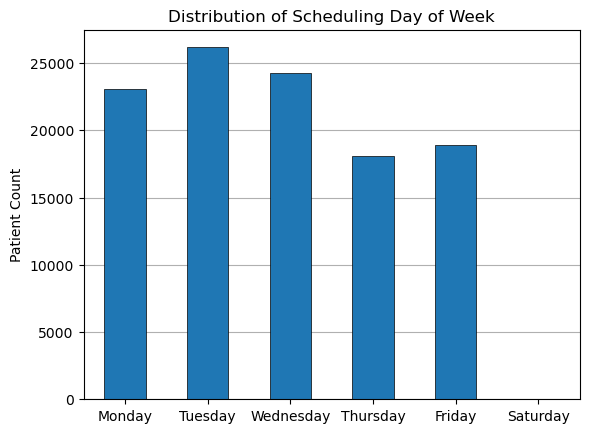

In [31]:
# Distribution of scheduled day of week
ax = scheduled_day_of_week.plot(kind = 'bar',
        x = 'Scheduled_Day_of_Week',
        y = 'Patient_Count', 
        xlabel = '',
        ylabel = 'Patient Count',
        title = 'Distribution of Scheduling Day of Week',
        edgecolor = 'black',
        linewidth = 0.5,
        rot = 0,
        #xlim = [-1,70],
        #xticks = xticks,
        #bins = bins,
        )
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.get_legend().remove()

# Save the figure
plt.savefig("output/Scheduling_day_of_week_distribution.png")
# Show figure
plt.show()

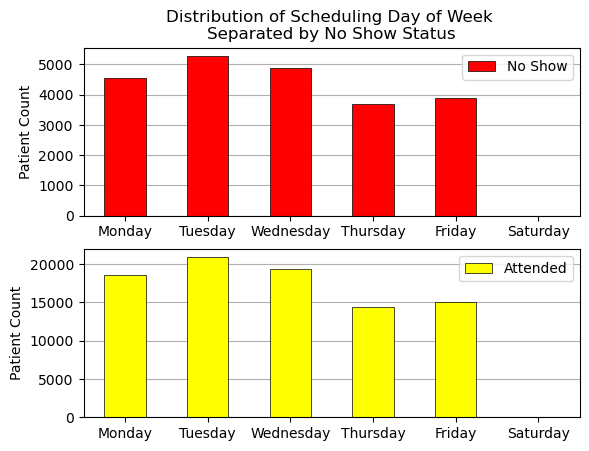

In [32]:
# Distribution of scheduled day of week
# Separated by no show and attended

# No shows
scheduled_day_of_week_no_show = df[df['No_Show_Boolean']==True].groupby('Scheduled_Day_of_Week')['Patient_ID'].count().reset_index()
scheduled_day_of_week_no_show.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
scheduled_day_of_week_no_show = scheduled_day_of_week_no_show.reindex(index=[1,4,5,3,0,2]).reset_index() # reorder rows 
scheduled_day_of_week_no_show.drop(columns=['index'], inplace=True) # remove old index

fig, ax = plt.subplots(nrows=2, ncols=1)
plot1 = scheduled_day_of_week_no_show.plot(ax=ax[0],
        kind = 'bar', 
        x = 'Scheduled_Day_of_Week',
        y = 'Patient_Count', 
        xlabel = '',
        ylabel = 'Patient Count',
        title = 'Distribution of Scheduling Day of Week \nSeparated by No Show Status',
        edgecolor = 'black',
        color='red',
        linewidth = 0.5,
        rot = 0,
        label = "No Show",
        #ylim = [0,.18]
        )
ax[0].grid(axis='y')
ax[0].set_axisbelow(True)
# Add legend
ax[0].legend()

# Attended
scheduled_day_of_week_attended = df[df['No_Show_Boolean']==False].groupby('Scheduled_Day_of_Week')['Patient_ID'].count().reset_index()
scheduled_day_of_week_attended.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
scheduled_day_of_week_attended = scheduled_day_of_week_attended.reindex(index=[1,4,5,3,0,2]).reset_index() # reorder rows 
scheduled_day_of_week_attended.drop(columns=['index'], inplace=True) # remove old index

plot2 = scheduled_day_of_week_attended.plot(ax=ax[1],
        kind = 'bar', 
        x = 'Scheduled_Day_of_Week',
        y = 'Patient_Count', 
        xlabel = '',
        ylabel = 'Patient Count',
        # title = 'Distribution of Scheduling Day of Week',
        edgecolor = 'black',
        color='yellow',
        linewidth = 0.5,
        rot = 0,
        label = "Attended",
        )
ax[1].grid(axis='y')
ax[1].set_axisbelow(True)
# Add legend
ax[1].legend()

# Save the figure
plt.savefig("output/Scheduling_day_of_week_distribution_separated.png")
# Show figure
plt.show()

In [33]:
# Find proportion of no shows by scheduling day of week
no_shows_by_scheduled_day_of_week = df.groupby('Scheduled_Day_of_Week')['No_Show_Boolean'].mean().reset_index()
no_shows_by_scheduled_day_of_week.rename(columns={'No_Show_Boolean':'No_Show_Proportion'},inplace=True)
no_shows_by_scheduled_day_of_week['Attended_Proportion'] = 1-no_shows_by_scheduled_day_of_week['No_Show_Proportion']
no_shows_by_scheduled_day_of_week = no_shows_by_scheduled_day_of_week.reindex(index=[1,4,5,3,0,2]).reset_index() # reorder rows 
no_shows_by_scheduled_day_of_week.drop(columns=['index'], inplace=True) # remove old index
no_shows_by_scheduled_day_of_week

,Scheduled_Day_of_Week,No_Show_Proportion,Attended_Proportion
0,Monday,0.197583,0.802417
1,Tuesday,0.202194,0.797806
2,Wednesday,0.201096,0.798904
3,Thursday,0.204725,0.795275
4,Friday,0.205498,0.794502
5,Saturday,0.041667,0.958333


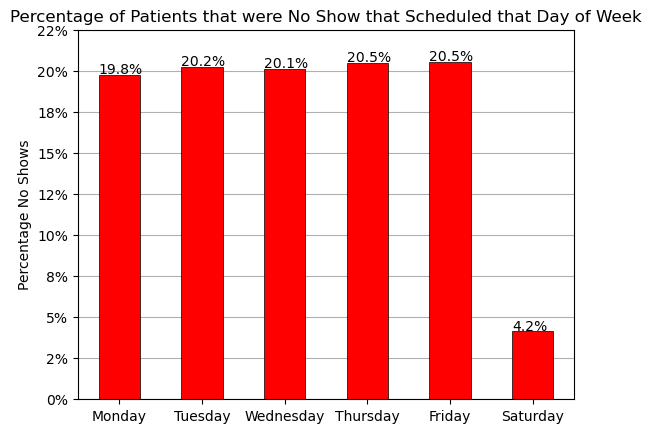

In [34]:
# Bar plot of no shows by scheduling day of week
ax = no_shows_by_scheduled_day_of_week.plot(kind = 'bar', 
        #stacked = True,
        x = 'Scheduled_Day_of_Week',
        y = 'No_Show_Proportion',
        xlabel = '',
        ylabel = 'Percentage No Shows',
        title = 'Percentage of Patients that were No Show that Scheduled that Day of Week',
        edgecolor = 'black',
        color = 'red',
        linewidth = 0.5,
        rot = 0,
        ylim = [0,.21],
        #yticks=[.18,.19,.20,.21,.22,.23,.24]
        )
# horizontal grid lines
ax.grid(axis='y') 
ax.set_axisbelow(True)

# change format of yticks to percentages
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels(['{:,.0%}'.format(ytick) for ytick in vals])

# Label bar heights
for p in ax.patches:
    ax.annotate(str(round(p.get_height()*100,1)) + '%', (p.get_x(), p.get_height() * 1.005))

# Remove legend
ax.get_legend().remove()

# Save the figure
plt.savefig("output/No_shows_by_scheduling_day_of_week.png")
# Show figure
plt.show()

In [35]:
# Find aveage days between for scheduled day of week
# This is done to investigate why scheduling Saturday gives a lower percenage of no shows
days_between_by_scheduled_day_of_week = df.groupby('Scheduled_Day_of_Week')['Days_Between'].mean().reset_index()
days_between_by_scheduled_day_of_week

,Scheduled_Day_of_Week,Days_Between
0,Friday,10.854718
1,Monday,9.529241
2,Saturday,10.916667
3,Thursday,9.751065
4,Tuesday,10.713658
5,Wednesday,10.034457


In [36]:
# Find proporiton of same day appointments by day of week
# This is done to investigate why scheduling Saturday gives a lower percenage of no shows
same_day_appt_by_day_of_week = df[df['Days_Between']==0]['Scheduled_Day_of_Week'].value_counts()
num_sched_appt_by_day_of_week = df['Scheduled_Day_of_Week'].value_counts()
same_day_appt_by_day_of_week/num_sched_appt_by_day_of_week

Scheduled_Day_of_Week
Tuesday      0.350657
Wednesday    0.363614
Monday       0.352279
Friday       0.343801
Thursday     0.327616
Saturday     0.333333
Name: count, dtype: float64

Saturday does no have a greater proportion of same-day appointments or fewer days between scheduling and appointment.

### No Shows by Scheduling Hour of Day
Does the time of day that an appointment is scheduled impact the chances of the patient showing up?

Conclusions: 
- In general, shceduling appointments earlier in the day results in a smaller chance of missing the appointment.
- Scheduling appointments late in the day greatly increases the chance of missing the appointment in the future.
- This suggests that in the moring people typically have a better idea of their future schedules.

In [37]:
# Number of patients that scheduled that hour
scheduled_hour = df.groupby('Scheduled_Hour')['Patient_ID'].count().reset_index()
scheduled_hour.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
scheduled_hour

,Scheduled_Hour,Patient_Count
0,6,1578
1,7,19213
2,8,15348
3,9,12823
4,10,11056
5,11,8462
6,12,5422
7,13,9036
8,14,9127
9,15,8079


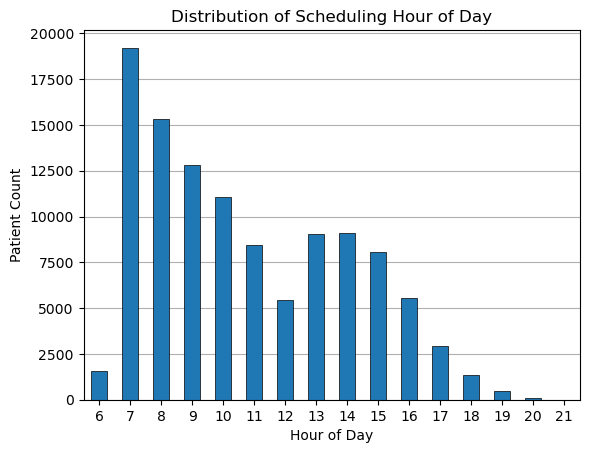

In [38]:
# Distribution of scheduled hour of day
ax = scheduled_hour.plot(kind = 'bar',
        x = 'Scheduled_Hour',
        y = 'Patient_Count', 
        xlabel = 'Hour of Day',
        ylabel = 'Patient Count',
        title = 'Distribution of Scheduling Hour of Day',
        edgecolor = 'black',
        linewidth = 0.5,
        rot = 0,
        #xlim = [-1,70],
        #xticks = xticks,
        #bins = bins,
        )
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.get_legend().remove()

# Save the figure
plt.savefig("output/Scheduling_hour_distribution.png")
# Show figure
plt.show()

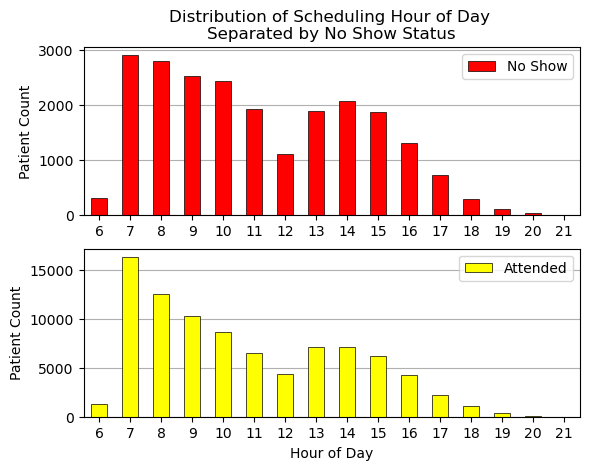

In [39]:
# Distribution of scheduled hour of day
# Separated by no show and attended

# No Shows
scheduled_hour_no_show = df[df['No_Show_Boolean']==True].groupby('Scheduled_Hour')['Patient_ID'].count().reset_index()
scheduled_hour_no_show.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)

fig, ax = plt.subplots(nrows=2, ncols=1)
plot1 = scheduled_hour_no_show.plot(ax=ax[0],
        kind = 'bar', 
        x = 'Scheduled_Hour',
        y = 'Patient_Count', 
        xlabel = '',
        ylabel = 'Patient Count',
        title = 'Distribution of Scheduling Hour of Day \nSeparated by No Show Status',
        edgecolor = 'black',
        color='red',
        linewidth = 0.5,
        rot = 0,
        label = "No Show",
        #ylim = [0,.18]
        )
ax[0].grid(axis='y')
ax[0].set_axisbelow(True)
# Add legend
ax[0].legend()

# Attended
scheduled_hour_attended = df[df['No_Show_Boolean']==False].groupby('Scheduled_Hour')['Patient_ID'].count().reset_index()
scheduled_hour_attended.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)

plot2 = scheduled_hour_attended.plot(ax=ax[1],
        kind = 'bar', 
        x = 'Scheduled_Hour',
        y = 'Patient_Count', 
        xlabel = 'Hour of Day',
        ylabel = 'Patient Count',
        # title = 'Distribution of Scheduling Hour of Day',
        edgecolor = 'black',
        color='yellow',
        linewidth = 0.5,
        rot = 0,
        label = "Attended",
        )
ax[1].grid(axis='y')
ax[1].set_axisbelow(True)
# Add legend
ax[1].legend()

# Save the figure
plt.savefig("output/Scheduling_hour_separated.png")
# Show figure
plt.show()

In [40]:
# Find proportion of no shows by scheduling hour
no_shows_by_scheduled_hour = df.groupby('Scheduled_Hour')['No_Show_Boolean'].mean().reset_index()
no_shows_by_scheduled_hour.rename(columns={'No_Show_Boolean':'No_Show_Proportion'},inplace=True)
no_shows_by_scheduled_hour['Attended_Proportion'] = 1-no_shows_by_scheduled_hour['No_Show_Proportion']
no_shows_by_scheduled_hour

,Scheduled_Hour,No_Show_Proportion,Attended_Proportion
0,6,0.192015,0.807985
1,7,0.151512,0.848488
2,8,0.182695,0.817305
3,9,0.196990,0.803010
4,10,0.220695,0.779305
5,11,0.227842,0.772158
6,12,0.203615,0.796385
7,13,0.209274,0.790726
8,14,0.226800,0.773200
9,15,0.231836,0.768164


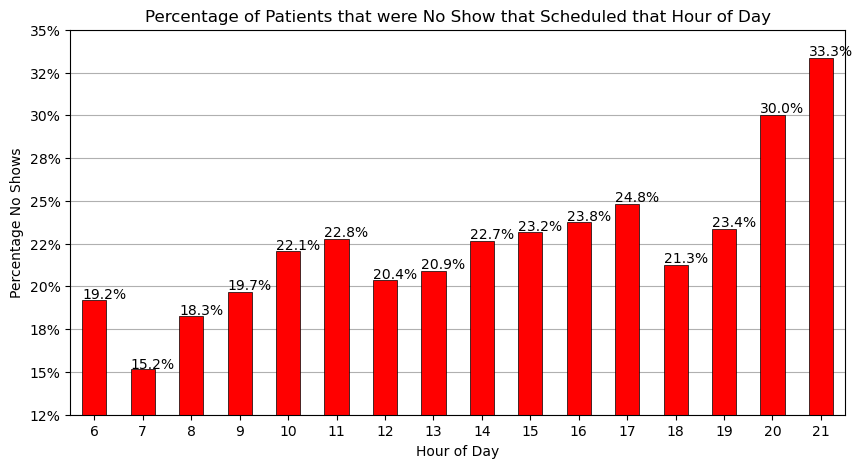

In [41]:
# Bar plot of no shows by scheduling hour
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax = no_shows_by_scheduled_hour.plot(ax = ax,
        kind = 'bar', 
        #stacked = True,
        x = 'Scheduled_Hour',
        y = 'No_Show_Proportion',
        xlabel = 'Hour of Day',
        ylabel = 'Percentage No Shows',
        title = 'Percentage of Patients that were No Show that Scheduled that Hour of Day',
        edgecolor = 'black',
        color = 'red',
        linewidth = 0.5,
        rot = 0,
        ylim = [.14,.34],
        #yticks=[.18,.19,.20,.21,.22,.23,.24]
        )
# Horizontal grid lines
ax.grid(axis='y') 
ax.set_axisbelow(True)

# Change format of yticks to percentages
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels(['{:,.0%}'.format(ytick) for ytick in vals])

# Label bar heights
for p in ax.patches:
    ax.annotate(str(round(p.get_height()*100,1)) + '%', (p.get_x(), p.get_height() * 1.005))

# Remove legend
ax.get_legend().remove()

# Save the figure
plt.savefig("output/No_shows_by_scheduling_hour.png")
# Show figure
plt.show()

### No Shows by Scheduling Month
Does the month of year that an appointment is scheduled impact the chances of the patient showing up?

It turns out there is not enough data in the dataset for this analysis, since the appointments only span three months (April, May, June). This will bias towards the shorter Days_Between for the months at the end of the time period, which is going to bias towards a smaller no show percentage for months at the end of the time period. 

In [42]:
# Number of patients that scheduled that month
scheduled_month = df.groupby('Scheduled_Month')['Patient_ID'].count().reset_index()
scheduled_month.rename(columns={'Patient_ID':'Patient_Count'},inplace=True)
scheduled_month

,Scheduled_Month,Patient_Count
0,1,60
1,2,281
2,3,3614
3,4,25339
4,5,67421
5,6,13749
6,11,1
7,12,61


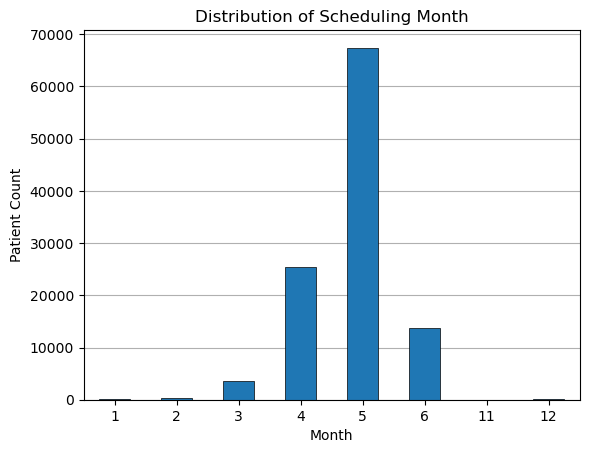

In [43]:
# Distribution of scheduled hour of day
ax = scheduled_month.plot(kind = 'bar',
        x = 'Scheduled_Month',
        y = 'Patient_Count', 
        xlabel = 'Month',
        ylabel = 'Patient Count',
        title = 'Distribution of Scheduling Month',
        edgecolor = 'black',
        linewidth = 0.5,
        rot = 0,
        #xlim = [-1,70],
        #xticks = xticks,
        #bins = bins,
        )
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.get_legend().remove()
plt.show()

In [44]:
# Find proportion of no shows by scheduling month
no_shows_by_scheduled_month = df.groupby('Scheduled_Month')['No_Show_Boolean'].mean().reset_index()
no_shows_by_scheduled_month.rename(columns={'No_Show_Boolean':'No_Show_Proportion'},inplace=True)
no_shows_by_scheduled_month['Attended_Proportion'] = 1-no_shows_by_scheduled_month['No_Show_Proportion']
no_shows_by_scheduled_month

,Scheduled_Month,No_Show_Proportion,Attended_Proportion
0,1,0.300000,0.700000
1,2,0.291815,0.708185
2,3,0.330935,0.669065
3,4,0.309760,0.690240
4,5,0.174560,0.825440
5,6,0.100807,0.899193
6,11,0.000000,1.000000
7,12,0.311475,0.688525


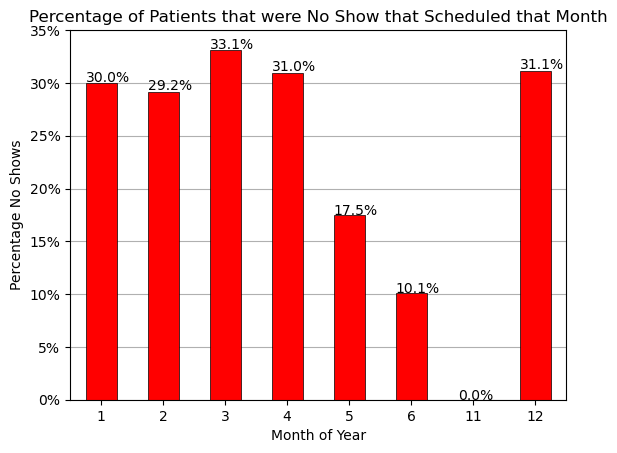

In [45]:
# Bar plot of no shows by scheduling month
ax = no_shows_by_scheduled_month.plot(kind = 'bar', 
        #stacked = True,
        x = 'Scheduled_Month',
        y = 'No_Show_Proportion',
        xlabel = 'Month of Year',
        ylabel = 'Percentage No Shows',
        title = 'Percentage of Patients that were No Show that Scheduled that Month',
        edgecolor = 'black',
        color = 'red',
        linewidth = 0.5,
        rot = 0,
        ylim = [0,.35],
        #yticks=[.18,.19,.20,.21,.22,.23,.24]
        )
# Horizontal grid lines
ax.grid(axis='y') 
ax.set_axisbelow(True)

# Change format of yticks to percentages
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels(['{:,.0%}'.format(ytick) for ytick in vals])

# Label bar heights
for p in ax.patches:
    ax.annotate(str(round(p.get_height()*100,1)) + '%', (p.get_x(), p.get_height() * 1.005))

# Remove legend
ax.get_legend().remove()

plt.show()